# Detecção de Fraude em contratos de seguros: Mitigar  Bias, Treinar, Registrar, e Deploy do modelo

## Background

Este notebook é a segunda parte de uma série de notebooks que demonstrarão como preparar, treinar e implantar um modelo que detecta reclamações automáticas fraudulentas. Neste notebook, estaremos preparando, processando e armazenando recursos usando o SageMaker Feature Store. Você pode optar por executar este notebook sozinho ou em sequência com os outros notebooks listados abaixo. Consulte o [README.md](README.md) para obter mais informações sobre este caso de uso implementado por esta série de notebooks.

1. **[Detecção de Fraude em contratos de seguros: exploração de dados](./0-AutoClaimFraudDetection.ipynb)**
1. [Detecção de Fraude em contratos de seguros: preparação de dados, processo e recursos de armazenamento](./1-data-prep-e2e.ipynb)
1. [Detecção de Fraude em contratos de seguros: treinar, verificar viés, ajustar, registrar linhagem e registrar um modelo](./2-lineage-train-assess-bias-tune-registry-e2e.ipynb)
1. [Detecção de Fraude em contratos de seguros: mitigar, treinar, registrar e implantar modelo imparcial](./3-mitigate-bias-train-model2-registry-e2e.ipynb)


## Conteúdo
1. [Arquitetura para preparação de dados, recursos e armazenamento](#Arquitetura para preparação de dados, recursos de processo e armazenamento)
1. [Introdução: Criando recursos](#Getting-Started:-Creating-Resources)
1. [Conjuntos de dados e tipos de recursos](#Datasets-and-Feature-Types)
1. [SageMaker Feature Store](#SageMaker-Feature-Store)
1. [Criar conjuntos de dados de treinamento e teste](#Create-Train-and-Test-Datasets)

### Instale as bibliotecas de terceiros necessárias e/ou atualize

In [2]:
!python -m pip install -Uq pip
!python -m pip install -q awswrangler==2.2.0 imbalanced-learn==0.7.0 sagemaker==2.23.0 boto3==1.17.70

### Importar Bibliotecas

In [3]:
import json
import time
import boto3
import sagemaker
import numpy as np
import pandas as pd
import awswrangler as wr
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sagemaker.xgboost.estimator import XGBoost

from model_package_src.inference_specification import InferenceSpecification

%matplotlib inline

### Selecione a região, boto3 e SageMaker SDK 

In [4]:
# You can change this to a region of your choice
import sagemaker

region = sagemaker.Session().boto_region_name
print("Using AWS Region: {}".format(region))

Using AWS Region: us-east-1


In [5]:
boto3.setup_default_session(region_name=region)

boto_session = boto3.Session(region_name=region)

s3_client = boto3.client("s3", region_name=region)

sagemaker_boto_client = boto_session.client("sagemaker")

sagemaker_session = sagemaker.Session(
    boto_session=boto_session, sagemaker_client=sagemaker_boto_client
)

sagemaker_role = sagemaker.get_execution_role()

account_id = boto3.client("sts").get_caller_identity()["Account"]

In [6]:
# variables used for parameterizing the notebook run
bucket = sagemaker_session.default_bucket()
prefix = "fraud-detect-demo"

claims_fg_name = f"{prefix}-claims"
customers_fg_name = f"{prefix}-customers"

model_2_name = f"{prefix}-xgboost-post-smote"

train_data_upsampled_s3_path = f"s3://{bucket}/{prefix}/data/train/upsampled/train.csv"
bias_report_2_output_path = f"s3://{bucket}/{prefix}/clarify-output/bias-2"
explainability_output_path = f"s3://{bucket}/{prefix}/clarify-output/explainability"

train_instance_count = 1
train_instance_type = "ml.m4.xlarge"

claify_instance_count = 1
clairfy_instance_type = "ml.c5.xlarge"

## Arquitetura: Treinar, Verificar Bias, otimizar parâmetros, registrar linhagem, registrar o modelo
----

![train-assess-tune-register](./images/e2e-2-pipeline-v3b.png)

## Desenvolva um modelo imparcial (sem viés)
----

Neste segundo modelo, você corrigirá o desequilíbrio de gênero no conjunto de dados usando SMOTE e treinará outro modelo usando XGBoost. Esse modelo também será salvo em nosso registro e, eventualmente, aprovado para implantação.

In [7]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

<a id='smote'></a>

### Resolva o desequilíbrio de classe usando SMOTE

Para lidar com o desequilíbrio, podemos fazer uma sobreamostragem (ou seja, aumentar a amostra) da classe minoritária usando [SMOTE (Synthetic Minority Over-sampling Technique)](https://arxiv.org/pdf/1106.1813.pdf). Depois de instalar o módulo de aprendizado desbalanceado, se você receber um ImportError ao importar o SMOTE, tente reiniciar o kernel.

#### Equilíbrio de gênero antes do SMOTE

In [8]:
gender = train["customer_gender_female"]
gender.value_counts()

0    2782
1    1218
Name: customer_gender_female, dtype: int64

#### Equilíbrio de gênero após SMOTE

In [9]:
sm = SMOTE(random_state=42)
train_data_upsampled, gender_res = sm.fit_resample(train, gender)
train_data_upsampled["customer_gender_female"].value_counts()

1    2782
0    2782
Name: customer_gender_female, dtype: int64

### Defina os hiperparâmetros
Estes são os parâmetros que serão enviados ao nosso script de treinamento para treinar o modelo. Embora todos sejam definidos como "hiperparâmetros" aqui, eles podem abranger os [Parâmetros da tarefa de aprendizado](https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters) do XGBoost, [Parâmetros do impulsionador da árvore ](https://xgboost.readthedocs.io/en/latest/parameter.html#parameters-for-tree-booster) ou qualquer outro parâmetro que você queira configurar para o XGBoost.

In [10]:
hyperparameters = {
    "max_depth": "3",
    "eta": "0.2",
    "objective": "binary:logistic",
    "num_round": "100",
}

### Treine o novo Modelo


In [11]:
train_data_upsampled.to_csv("data/upsampled_train.csv", index=False)
s3_client.upload_file(
    Filename="data/upsampled_train.csv",
    Bucket=bucket,
    Key=f"{prefix}/data/train/upsampled/train.csv",
)

In [12]:
xgb_estimator = XGBoost(
    entry_point="xgboost_starter_script.py",
    hyperparameters=hyperparameters,
    role=sagemaker_role,
    instance_count=train_instance_count,
    instance_type=train_instance_type,
    framework_version="1.0-1",
)

In [13]:
if "training_job_2_name" not in locals():

    xgb_estimator.fit(inputs={"train": train_data_upsampled_s3_path})
    training_job_2_name = xgb_estimator.latest_training_job.job_name

else:

    print(f"Using previous training job: {training_job_2_name}")

2022-08-28 11:28:27 Starting - Starting the training job...
2022-08-28 11:28:53 Starting - Preparing the instances for trainingProfilerReport-1661686107: InProgress
.........
2022-08-28 11:30:14 Downloading - Downloading input data...
2022-08-28 11:30:54 Training - Downloading the training image......
2022-08-28 11:31:51 Training - Training image download completed. Training in progress..INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Invoking user training script.
INFO:sagemaker-containers:Module xgboost_starter_script does not provide a setup.py. 
Generating setup.py
INFO:sagemaker-containers:Generating setup.cfg
INFO:sagemaker-containers:Generating MANIFEST.in
INFO:sagemaker-containers:Installing module with the following command:
/miniconda3/bin/python3 -m pip install . 
Processing /opt/ml/code
  Created wheel for xgboost-starter-scrip

### Registre os Artefatos

In [14]:
training_job_2_info = sagemaker_boto_client.describe_training_job(
    TrainingJobName=training_job_2_name
)

In [15]:
# return any existing artifact which match the our training job's code arn
code_s3_uri = training_job_2_info["HyperParameters"]["sagemaker_submit_directory"]

list_response = list(
    sagemaker.lineage.artifact.Artifact.list(
        source_uri=code_s3_uri, sagemaker_session=sagemaker_session
    )
)

# use existing arifact if it's already been created, otherwise create a new artifact
if list_response:
    code_artifact = list_response[0]
    print(f"Using existing artifact: {code_artifact.artifact_arn}")
else:
    code_artifact = sagemaker.lineage.artifact.Artifact.create(
        artifact_name="TrainingScript",
        source_uri=code_s3_uri,
        artifact_type="Code",
        sagemaker_session=sagemaker_session,
    )
    print(f"Create artifact {code_artifact.artifact_arn}: SUCCESSFUL")

Create artifact arn:aws:sagemaker:us-east-1:173965381620:artifact/b83a3c5dba77e73b41cea6824332d503: SUCCESSFUL


#### Treinando os Artefatos

In [16]:
training_data_s3_uri = training_job_2_info["InputDataConfig"][0]["DataSource"]["S3DataSource"][
    "S3Uri"
]

list_response = list(
    sagemaker.lineage.artifact.Artifact.list(
        source_uri=training_data_s3_uri, sagemaker_session=sagemaker_session
    )
)

if list_response:
    training_data_artifact = list_response[0]
    print(f"Using existing artifact: {training_data_artifact.artifact_arn}")
else:
    training_data_artifact = sagemaker.lineage.artifact.Artifact.create(
        artifact_name="TrainingData",
        source_uri=training_data_s3_uri,
        artifact_type="Dataset",
        sagemaker_session=sagemaker_session,
    )
    print(f"Create artifact {training_data_artifact.artifact_arn}: SUCCESSFUL")

Using existing artifact: arn:aws:sagemaker:us-east-1:173965381620:artifact/64feefeb4fa174b4c0a26d08648b7f74


#### Artefatos/Modelo

In [17]:
trained_model_s3_uri = training_job_2_info["ModelArtifacts"]["S3ModelArtifacts"]

list_response = list(
    sagemaker.lineage.artifact.Artifact.list(
        source_uri=trained_model_s3_uri, sagemaker_session=sagemaker_session
    )
)

if list_response:
    model_artifact = list_response[0]
    print(f"Using existing artifact: {model_artifact.artifact_arn}")
else:
    model_artifact = sagemaker.lineage.artifact.Artifact.create(
        artifact_name="TrainedModel",
        source_uri=trained_model_s3_uri,
        artifact_type="Model",
        sagemaker_session=sagemaker_session,
    )
    print(f"Create artifact {model_artifact.artifact_arn}: SUCCESSFUL")

Using existing artifact: arn:aws:sagemaker:us-east-1:173965381620:artifact/7f2b40bba8fd5bc4017fc275db92ad56


### Definir associações de artefatos

In [18]:
trial_component = sagemaker_boto_client.describe_trial_component(
    TrialComponentName=training_job_2_name + "-aws-training-job"
)
trial_component_arn = trial_component["TrialComponentArn"]

#### Entrada

In [19]:
input_artifacts = [code_artifact, training_data_artifact]

for a in input_artifacts:
    try:
        sagemaker.lineage.association.Association.create(
            source_arn=a.artifact_arn,
            destination_arn=trial_component_arn,
            association_type="ContributedTo",
            sagemaker_session=sagemaker_session,
        )
        print(f"Associate {trial_component_arn} and {a.artifact_arn}: SUCCEESFUL\n")
    except:
        print(f"Association already exists between {trial_component_arn} and {a.artifact_arn}.\n")

Associate arn:aws:sagemaker:us-east-1:173965381620:experiment-trial-component/sagemaker-xgboost-2022-08-28-11-28-27-693-aws-training-job and arn:aws:sagemaker:us-east-1:173965381620:artifact/b83a3c5dba77e73b41cea6824332d503: SUCCEESFUL

Association already exists between arn:aws:sagemaker:us-east-1:173965381620:experiment-trial-component/sagemaker-xgboost-2022-08-28-11-28-27-693-aws-training-job and arn:aws:sagemaker:us-east-1:173965381620:artifact/64feefeb4fa174b4c0a26d08648b7f74.



#### Saída

In [20]:
output_artifacts = [model_artifact]

for artifact_arn in output_artifacts:
    try:
        sagemaker.lineage.association.Association.create(
            source_arn=a.artifact_arn,
            destination_arn=trial_component_arn,
            association_type="Produced",
            sagemaker_session=sagemaker_session,
        )
        print(f"Associate {trial_component_arn} and {a.artifact_arn}: SUCCEESFUL\n")
    except:
        print(f"Association already exists between {trial_component_arn} and {a.artifact_arn}.\n")

Association already exists between arn:aws:sagemaker:us-east-1:173965381620:experiment-trial-component/sagemaker-xgboost-2022-08-28-11-28-27-693-aws-training-job and arn:aws:sagemaker:us-east-1:173965381620:artifact/64feefeb4fa174b4c0a26d08648b7f74.



## Análise de viés e explicabilidade
----

O Amazon SageMaker Clariify fornece ferramentas para ajudar a explicar como os modelos de machine learning (ML) fazem previsões. Essas ferramentas podem ajudar os modeladores e desenvolvedores de ML e outras partes interessadas internas a entender as características do modelo como um todo antes da implantação e a depurar as previsões fornecidas pelo modelo após sua implantação. A transparência sobre como os modelos de ML chegam às suas previsões também é fundamental para consumidores e reguladores que precisam confiar nas previsões do modelo se quiserem aceitar as decisões baseadas nelas. O SageMaker Clarify usa uma abordagem de atribuição de recursos independente de modelo, que você pode usar para entender por que um modelo fez uma previsão após o treinamento e para fornecer explicações por instância durante a inferência. A implementação inclui uma implementação escalável e eficiente do SHAP ([consulte o artigo](https://papers.nips.cc/paper/2017/file/8a20a8621978632d76c43dfd28b67767-Paper.pdf)), com base no conceito de um valor Shapley do campo da teoria dos jogos cooperativos que atribui a cada característica um valor de importância para uma previsão particular.

### Criar Modelo a partir do Estimador

In [21]:
model_matches = sagemaker_boto_client.list_models(NameContains=model_2_name)['Models']

if not model_matches:
    
    model_2 = sagemaker_session.create_model_from_job(
        name=model_2_name,
        training_job_name=training_job_2_info['TrainingJobName'],
        role=sagemaker_role,
        image_uri=training_job_2_info['AlgorithmSpecification']['TrainingImage'])
    %store model_2_name
    
else:
    
    print(f"Model {model_2_name} already exists.")

Stored 'model_2_name' (str)


<a id='bias-v1'></a>

### Verifique o viés do conjunto de dados e o viés do modelo

Com o SageMaker, podemos verificar o viés pré e pós-treinamento. As métricas de pré-treinamento mostram viés preexistente nesses dados, enquanto as métricas de pós-treinamento mostram viés nas previsões do modelo. Usando o SDK do SageMaker, podemos especificar em quais grupos queremos verificar o viés e quais métricas gostaríamos de mostrar.

Para executar o trabalho completo do Clarify, você deve descomentar o código na célula abaixo. A execução do trabalho levará cerca de 15 minutos. Se você deseja economizar tempo, pode visualizar os resultados na próxima célula, após a qual carrega uma saída pré-gerada se nenhum trabalho de polarização foi executado.

In [22]:
clarify_processor = sagemaker.clarify.SageMakerClarifyProcessor(
    role=sagemaker_role,
    instance_count=1,
    instance_type="ml.c4.xlarge",
    sagemaker_session=sagemaker_session,
)

bias_data_config = sagemaker.clarify.DataConfig(
    s3_data_input_path=train_data_upsampled_s3_path,
    s3_output_path=bias_report_2_output_path,
    label="fraud",
    headers=train.columns.to_list(),
    dataset_type="text/csv",
)

model_config = sagemaker.clarify.ModelConfig(
    model_name=model_2_name,
    instance_type=train_instance_type,
    instance_count=1,
    accept_type="text/csv",
)

predictions_config = sagemaker.clarify.ModelPredictedLabelConfig(probability_threshold=0.5)

bias_config = sagemaker.clarify.BiasConfig(
    label_values_or_threshold=[0],
    facet_name="customer_gender_female",
    facet_values_or_threshold=[1],
)

# # un-comment the code below to run the whole job

# if 'clarify_bias_job_2_name' not in locals():

#     clarify_processor.run_bias(
#         data_config=bias_data_config,
#         bias_config=bias_config,
#         model_config=model_config,
#         model_predicted_label_config=predictions_config,
#         pre_training_methods='all',
#         post_training_methods='all')

#     clarify_bias_job_2_name = clarify_processor.latest_job.name
#     %store clarify_bias_job_2_name

# else:
#     print(f'Clarify job {clarify_bias_job_2_name} has already run successfully.')

## Ver resultados do trabalho 
----

A execução do Clarify em seu conjunto de dados ou modelo pode levar cerca de 15 minutos. Se você não tiver tempo para executar o trabalho, poderá visualizar os resultados pré-gerados incluídos nesta demonstração. Caso contrário, você pode executar o trabalho removendo o comentário do código na célula acima.

In [23]:
if "clarify_bias_job_2_name" in locals():
    s3_client.download_file(
        Bucket=bucket,
        Key=f"{prefix}/clarify-output/bias-2/analysis.json",
        Filename="clarify_output/bias_2/analysis.json",
    )
    print(f"Downloaded analysis from previous Clarify job: {clarify_bias_job_2_name}\n")
else:
    print(f"Loading pre-generated analysis file...\n")

with open("clarify_output/bias_1/analysis.json", "r") as f:
    bias_analysis = json.load(f)

results = bias_analysis["pre_training_bias_metrics"]["facets"]["customer_gender_female"][0][
    "metrics"
][1]
print(json.dumps(results, indent=4))

with open("clarify_output/bias_2/analysis.json", "r") as f:
    bias_analysis = json.load(f)

results = bias_analysis["pre_training_bias_metrics"]["facets"]["customer_gender_female"][0][
    "metrics"
][1]
print(json.dumps(results, indent=4))

Loading pre-generated analysis file...

{
    "name": "CI",
    "description": "Class Imbalance (CI)",
    "value": 0.398
}
{
    "name": "CI",
    "description": "Class Imbalance (CI)",
    "value": 0.0
}


## Configurar e executar 
----

Para executar o trabalho completo do Clarify, você deve descomentar o código na célula abaixo. A execução do trabalho levará cerca de 15 minutos. Se você deseja economizar tempo, pode visualizar os resultados na próxima célula, após a qual carrega uma saída pré-gerada se nenhuma tarefa de explicabilidade tiver sido executada.

In [24]:
model_config = sagemaker.clarify.ModelConfig(
    model_name=model_2_name,
    instance_type=train_instance_type,
    instance_count=1,
    accept_type="text/csv",
)

shap_config = sagemaker.clarify.SHAPConfig(
    baseline=[train.median().values[1:].tolist()], num_samples=100, agg_method="mean_abs"
)

explainability_data_config = sagemaker.clarify.DataConfig(
    s3_data_input_path=train_data_upsampled_s3_path,
    s3_output_path=explainability_output_path,
    label="fraud",
    headers=train.columns.to_list(),
    dataset_type="text/csv",
)

# un-comment the code below to run the whole job

# if "clarify_expl_job_name" not in locals():

#     clarify_processor.run_explainability(
#         data_config=explainability_data_config,
#         model_config=model_config,
#         explainability_config=shap_config)

#     clarify_expl_job_name = clarify_processor.latest_job.name
#     %store clarify_expl_job_name

# else:
#     print(f'Clarify job {clarify_expl_job_name} has already run successfully.')

### Resultados da explicabilidade (atalho)
A execução do Clarify em seu conjunto de dados ou modelo pode levar cerca de 15 minutos. Se você não tiver tempo para executar o trabalho, poderá visualizar os resultados pré-gerados incluídos nesta demonstração. Caso contrário, você pode executar o trabalho removendo o comentário do código na célula acima.

Loading pre-generated analysis file...



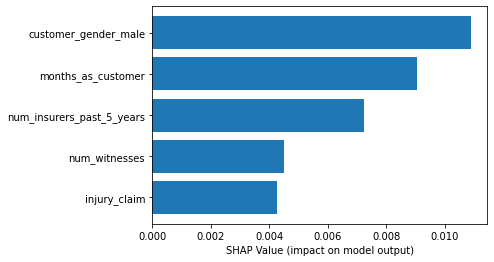

In [25]:
if "clarify_expl_job_name" in locals():
    s3_client.download_file(
        Bucket=bucket,
        Key=f"{prefix}/clarify-output/explainability/analysis.json",
        Filename="clarify_output/explainability/analysis.json",
    )
    print(f"Downloaded analysis from previous Clarify job: {clarify_expl_job_name}\n")
else:
    print(f"Loading pre-generated analysis file...\n")

with open("clarify_output/explainability/analysis.json", "r") as f:
    analysis_result = json.load(f)

shap_values = pd.DataFrame(analysis_result["explanations"]["kernel_shap"]["label0"])
importances = shap_values["global_shap_values"].sort_values(ascending=False)
fig, ax = plt.subplots()
n = 5
y_pos = np.arange(n)
importance_scores = importances.values[:n]
y_label = importances.index[:n]
ax.barh(y_pos, importance_scores, align="center")
ax.set_yticks(y_pos)
ax.set_yticklabels(y_label)
ax.invert_yaxis()
ax.set_xlabel("SHAP Value (impact on model output)");

Para ver o relatório do SageMaker Clarify gerado automaticamente, execute o código a seguir e use o link de saída para abrir o relatório.

In [26]:
from IPython.display import FileLink, FileLinks

display(
    "Click link below to view the SageMaker Clarify report", FileLink("clarify_output/report.pdf")
)

'Click link below to view the SageMaker Clarify report'

/root/-amazon-sagemaker-fraude/clarify_output/report.pdf

### O que é SHAP?
SHAP é o método usado para calcular explicações nesta solução.
Ao contrário de outros métodos de atribuição de recursos, como recurso único
permutação, SHAP tenta desembaraçar o efeito de um único recurso por
olhando para todas as combinações possíveis de recursos.

[SHAP](https://github.com/slundberg/shap) (Lundberg et al. 2017)
para explicações do aditivo SHapley. 'Shapley' refere-se a uma teoria dos jogos
conceito chamado [Shapley
valores](https://en.wikipedia.org/wiki/Shapley_value) que é usado para
criar as explicações. Um valor Shapley descreve o valor marginal
contribuição de cada 'jogador' ao considerar todas as 'coalizões' possíveis.
Usando isso em um contexto de aprendizado de máquina, um valor Shapley descreve o
contribuição marginal de cada recurso ao considerar todos os conjuntos possíveis
de características. 'Aditivo' refere-se ao fato de que esses valores Shapley podem
ser somados para dar a previsão final do modelo.

Como exemplo, podemos começar com um risco de inadimplência de crédito de linha de base de
10%. Dado um conjunto de características, podemos calcular o valor de Shapley para cada
característica. Somando todos os valores de Shapley, podemos obter um
valor acumulado de +30%. Dado o mesmo conjunto de recursos, portanto,
esperamos que nosso modelo retorne um risco de inadimplência de crédito de 40% (ou seja, 10% + 30%).

#### Criar e fazer upload do segundo relatório de métricas do modelo

In [27]:
model_metrics_report = {"binary_classification_metrics": {}}
for metric in training_job_2_info["FinalMetricDataList"]:
    stat = {metric["MetricName"]: {"value": metric["Value"], "standard_deviation": "NaN"}}
    model_metrics_report["binary_classification_metrics"].update(stat)

with open("training_metrics.json", "w") as f:
    json.dump(model_metrics_report, f)

metrics_s3_key = (
    f"{prefix}/training_jobs/{training_job_2_info['TrainingJobName']}/training_metrics.json"
)
s3_client.upload_file(Filename="training_metrics.json", Bucket=bucket, Key=metrics_s3_key)

#### Definir especificação de inferência

In [28]:
mp_inference_spec = InferenceSpecification().get_inference_specification_dict(
    ecr_image=training_job_2_info["AlgorithmSpecification"]["TrainingImage"],
    supports_gpu=False,
    supported_content_types=["text/csv"],
    supported_mime_types=["text/csv"],
)

mp_inference_spec["InferenceSpecification"]["Containers"][0]["ModelDataUrl"] = training_job_2_info[
    "ModelArtifacts"
]["S3ModelArtifacts"]

#### Definir métricas do modelo

In [29]:
model_metrics = {
    "ModelQuality": {
        "Statistics": {
            "ContentType": "application/json",
            "S3Uri": f"s3://{bucket}/{metrics_s3_key}",
        }
    },
    "Bias": {
        "Report": {
            "ContentType": "application/json",
            "S3Uri": f"{explainability_output_path}/analysis.json",
        }
    },
}

#### Registre o segundo pacote de modelo no Grupo de Pacotes de Modelo

In [30]:
mpg_name = prefix
mp_input_dict = {
    "ModelPackageGroupName": mpg_name,
    "ModelPackageDescription": "XGBoost classifier to detect insurance fraud with SMOTE.",
    "ModelApprovalStatus": "PendingManualApproval",
    "ModelMetrics": model_metrics,
}

mp_input_dict.update(mp_inference_spec)
mp2_response = sagemaker_boto_client.create_model_package(**mp_input_dict)
mp2_arn = mp2_response["ModelPackageArn"]

#### Verifique o status da criação de modelo

In [31]:
mp_info = sagemaker_boto_client.describe_model_package(
    ModelPackageName=mp2_response["ModelPackageArn"]
)
mp_status = mp_info["ModelPackageStatus"]

while mp_status not in ["Completed", "Failed"]:
    time.sleep(5)
    mp_info = sagemaker_boto_client.describe_model_package(
        ModelPackageName=mp2_response["ModelPackageArn"]
    )
    mp_status = mp_info["ModelPackageStatus"]
    print(f"model package status: {mp_status}")
print(f"model package status: {mp_status}")

model package status: Completed


### Visualize os dois modelos no registro

In [32]:
sagemaker_boto_client.list_model_packages(ModelPackageGroupName=mpg_name)["ModelPackageSummaryList"]

[{'ModelPackageGroupName': 'fraud-detect-demo',
  'ModelPackageVersion': 2,
  'ModelPackageArn': 'arn:aws:sagemaker:us-east-1:173965381620:model-package/fraud-detect-demo/2',
  'ModelPackageDescription': 'XGBoost classifier to detect insurance fraud with SMOTE.',
  'CreationTime': datetime.datetime(2022, 8, 28, 11, 32, 46, 14000, tzinfo=tzlocal()),
  'ModelPackageStatus': 'Completed',
  'ModelApprovalStatus': 'PendingManualApproval'},
 {'ModelPackageGroupName': 'fraud-detect-demo',
  'ModelPackageVersion': 1,
  'ModelPackageArn': 'arn:aws:sagemaker:us-east-1:173965381620:model-package/fraud-detect-demo/1',
  'ModelPackageDescription': 'XGBoost classifier to detect insurance fraud.',
  'CreationTime': datetime.datetime(2022, 8, 28, 11, 27, 21, 592000, tzinfo=tzlocal()),
  'ModelPackageStatus': 'Completed',
  'ModelApprovalStatus': 'PendingManualApproval'}]

<a id ='implantar'> </a>

## Arquitetura: Deploy e servir o modelo
----

Agora que treinamos um modelo, podemos implantá-lo e servi-lo. A imagem a seguir mostra a arquitetura para fazer isso.

![train-assess-tune-register](./images/e2e-3-pipeline-v3b.png)

In [33]:
# variables used for parameterizing the notebook run
endpoint_name = f"{model_2_name}-endpoint"
endpoint_instance_count = 1
endpoint_instance_type = "ml.m4.xlarge"

predictor_instance_count = 1
predictor_instance_type = "ml.c5.xlarge"
batch_transform_instance_count = 1
batch_transform_instance_type = "ml.c5.xlarge"

## Implante um modelo aprovado e faça uma previsão

----

#### Aprovar o segundo modelo
No ciclo de vida de MLOps da vida real, um pacote de modelo é aprovado após avaliação por cientistas de dados, especialistas no assunto e auditores.

In [34]:
second_model_package = sagemaker_boto_client.list_model_packages(ModelPackageGroupName=mpg_name)[
    "ModelPackageSummaryList"
][0]
model_package_update = {
    "ModelPackageArn": second_model_package["ModelPackageArn"],
    "ModelApprovalStatus": "Approved",
}

update_response = sagemaker_boto_client.update_model_package(**model_package_update)

#### Crie uma configuração de endpoint e um endpoint
Implante o ponto de extremidade. Isso pode levar cerca de 8 minutos.

In [35]:
primary_container = {"ModelPackageName": second_model_package["ModelPackageArn"]}
endpoint_config_name = f"{model_2_name}-endpoint-config"
existing_configs = len(
    sagemaker_boto_client.list_endpoint_configs(NameContains=endpoint_config_name, MaxResults=30)[
        "EndpointConfigs"
    ]
)

if existing_configs == 0:
    create_ep_config_response = sagemaker_boto_client.create_endpoint_config(
        EndpointConfigName=endpoint_config_name,
        ProductionVariants=[
            {
                "InstanceType": endpoint_instance_type,
                "InitialVariantWeight": 1,
                "InitialInstanceCount": endpoint_instance_count,
                "ModelName": model_2_name,
                "VariantName": "AllTraffic",
            }
        ],
    )

In [36]:
existing_endpoints = sagemaker_boto_client.list_endpoints(
    NameContains=endpoint_name, MaxResults=30
)["Endpoints"]
if not existing_endpoints:
    create_endpoint_response = sagemaker_boto_client.create_endpoint(
        EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name
    )

endpoint_info = sagemaker_boto_client.describe_endpoint(EndpointName=endpoint_name)
endpoint_status = endpoint_info["EndpointStatus"]

while endpoint_status == "Creating":
    endpoint_info = sagemaker_boto_client.describe_endpoint(EndpointName=endpoint_name)
    endpoint_status = endpoint_info["EndpointStatus"]
    print("Endpoint status:", endpoint_status)
    if endpoint_status == "Creating":
        time.sleep(60)

Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: InService


## Executar previsões em reivindicações

<a id='predictor'> </a>

### Crie um preditor

In [37]:
predictor = sagemaker.predictor.Predictor(
    endpoint_name=endpoint_name, sagemaker_session=sagemaker_session
)

### Faça uma análise

In [38]:
dataset = pd.read_csv("data/dataset.csv")
train = dataset.sample(frac=0.8, random_state=0)
test = dataset.drop(train.index)
sample_policy_id = int(test.sample(1)["policy_id"])

In [39]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 4997
Data columns (total 48 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       1000 non-null   int64  
 1   policy_id                        1000 non-null   int64  
 2   collision_type_rear              1000 non-null   int64  
 3   customer_age                     1000 non-null   int64  
 4   vehicle_claim                    1000 non-null   float64
 5   incident_severity                1000 non-null   int64  
 6   authorities_contacted_ambulance  1000 non-null   int64  
 7   policy_liability                 1000 non-null   int64  
 8   total_claim_amount               1000 non-null   float64
 9   auto_year                        1000 non-null   int64  
 10  num_injuries                     1000 non-null   int64  
 11  num_vehicles_involved            1000 non-null   int64  
 12  driver_relationship_

In [40]:
dataset = pd.read_csv("./data/claims_customer.csv")
col_order = ["fraud"] + list(dataset.drop(["fraud", "Unnamed: 0", "policy_id"], axis=1).columns)
col_order

['fraud',
 'collision_type_rear',
 'customer_age',
 'vehicle_claim',
 'incident_severity',
 'authorities_contacted_ambulance',
 'policy_liability',
 'total_claim_amount',
 'auto_year',
 'num_injuries',
 'num_vehicles_involved',
 'driver_relationship_other',
 'incident_type_theft',
 'collision_type_front',
 'incident_type_breakin',
 'policy_annual_premium',
 'num_witnesses',
 'policy_state_wa',
 'driver_relationship_spouse',
 'policy_state_or',
 'authorities_contacted_police',
 'incident_dow',
 'collision_type_na',
 'driver_relationship_na',
 'driver_relationship_self',
 'num_insurers_past_5_years',
 'months_as_customer',
 'incident_type_collision',
 'customer_education',
 'collision_type_side',
 'incident_hour',
 'incident_month',
 'num_claims_past_year',
 'policy_state_ca',
 'driver_relationship_child',
 'customer_gender_female',
 'incident_day',
 'injury_claim',
 'policy_deductable',
 'authorities_contacted_fire',
 'police_report_available',
 'customer_gender_male',
 'policy_state_az

In [41]:
col_order

['fraud',
 'collision_type_rear',
 'customer_age',
 'vehicle_claim',
 'incident_severity',
 'authorities_contacted_ambulance',
 'policy_liability',
 'total_claim_amount',
 'auto_year',
 'num_injuries',
 'num_vehicles_involved',
 'driver_relationship_other',
 'incident_type_theft',
 'collision_type_front',
 'incident_type_breakin',
 'policy_annual_premium',
 'num_witnesses',
 'policy_state_wa',
 'driver_relationship_spouse',
 'policy_state_or',
 'authorities_contacted_police',
 'incident_dow',
 'collision_type_na',
 'driver_relationship_na',
 'driver_relationship_self',
 'num_insurers_past_5_years',
 'months_as_customer',
 'incident_type_collision',
 'customer_education',
 'collision_type_side',
 'incident_hour',
 'incident_month',
 'num_claims_past_year',
 'policy_state_ca',
 'driver_relationship_child',
 'customer_gender_female',
 'incident_day',
 'injury_claim',
 'policy_deductable',
 'authorities_contacted_fire',
 'police_report_available',
 'customer_gender_male',
 'policy_state_az

### Extraia os dados do cliente e formate o Endpoint
Quando um cliente envia uma solicitação de seguro on-line para aprovação instantânea, a seguradora precisará obter dados específicos do cliente. Você pode fazer isso usando os dados do cliente que armazenamos em arquivos CSV ou uma loja de recursos online para adicionar aos dados da reclamação. Os dados extraídos servirão como entrada para uma previsão do modelo.

Em seguida, o ponto de dados deve corresponder ao formato de entrada exato conforme o modelo foi treinado - com todos os recursos na ordem correta. Neste exemplo, a variável `col_order` foi salva quando você criou os conjuntos de dados de treinamento e teste anteriormente no guia.

In [42]:
sample_policy_id = int(test.sample(1)["policy_id"])
pull_from_feature_store = False

if pull_from_feature_store:
    customers_response = featurestore_runtime.get_record(
        FeatureGroupName=customers_fg_name, RecordIdentifierValueAsString=str(sample_policy_id)
    )

    customer_record = customers_response["Record"]
    customer_df = pd.DataFrame(customer_record).set_index("FeatureName")

    claims_response = featurestore_runtime.get_record(
        FeatureGroupName=claims_fg_name, RecordIdentifierValueAsString=str(sample_policy_id)
    )

    claims_record = claims_response["Record"]
    claims_df = pd.DataFrame(claims_record).set_index("FeatureName")

    blended_df = pd.concat([claims_df, customer_df]).loc[col_order].drop("fraud")
else:
    customer_claim_df = dataset[dataset["policy_id"] == sample_policy_id].sample(1)
    blended_df = customer_claim_df.loc[:, col_order].drop("fraud", axis=1).T.reset_index()
    blended_df.columns = ["FeatureName", "ValueAsString"]

data_input = ",".join([str(x) for x in blended_df["ValueAsString"]])
data_input

'1.0,65.0,10500.0,0.0,0.0,0.0,10500.0,2017.0,0.0,2.0,0.0,0.0,0.0,0.0,3000.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,2.0,1.0,4.0,0.0,21.0,6.0,0.0,1.0,0.0,0.0,4.0,0.0,750.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0'

### Fazer previsão

In [43]:
results = predictor.predict(data_input, initial_args={"ContentType": "text/csv"})
prediction = json.loads(results)
print(f"Probablitity the claim from policy {int(sample_policy_id)} is fraudulent:", prediction)

Probablitity the claim from policy 1697 is fraudulent: 0.1563970446586609
